**Aluno**: Artur Chiaperini Grover.     



# Trabalho 5 - Transformada de Hough

Faça um documento jupyter notebook que forneça, com base na transformada de Hough modelada para círculos, a contagem e a descrição (coordenadas dos centros e raio) dos discos grandes presentes na imagem do exemplo (do trabalho 3 - segmentação dos discos claros usando a transformada top-hat). 

-------

Procedimento sugerido:

Use como base o resultado do trabalho 3. Inicialmente, subtraia o resultado do trabalho 3 da imagem original a fim de obter a segmentação dos discos. Em seguida, utilize um filtro para obter as bordas dos discos e binarize o resultado. Por fim, empregue a transformada de Hough para obter as informações desejadas.

-------

#### Bibliotecas

In [1]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

-------

# Funções

Para resolver o problema de identificar as circunferências, criamos as funções a seguir:

* ```img_threshold```: limiarização da imagem, o limiar pode ser dado como parâmetro para a função;
* ```img2binary```: binarização da imagem;
* ```sobel```: aplica o filtro sobel na imagem;
* ```plota```: função para exibir as imagens;
* ```remove_straight_edges```: remove as linhas horizontais e verticais da imagem.

In [2]:
def img_threshold(img, threshold = 60):
    '''Performs limiarization of an image'''
    return threshold < img

In [3]:
def img2binary(img):
    '''Binarization of image with threshold given'''
    img[img > 0] = 1
    return img

In [4]:
def sobel(img):
    '''Apply sobel filter on an image'''
    sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobely = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    gx = cv.convertScaleAbs(cv.filter2D(img, 
                                        cv.CV_64F,
                                        cv.flip(sobelx, -1)))
    gy = cv.convertScaleAbs(cv.filter2D(img,
                                        cv.CV_64F,
                                        cv.flip(sobely, -1)))
    
    return gx + gy

In [5]:
def plota(img, gray = True, save = False, name = ''):
    num = len(img)
    fig = plt.figure(figsize = (15, 9))
    grid = plt.GridSpec(1, num, fig)
    
    for i in range(num):
        ax = fig.add_subplot(grid[0, i])
        if gray:
            ax.imshow(img[i], cmap = 'gray')
        else:
            ax.imshow(img[i])
        ax.set_xticks([])
        ax.set_yticks([])
        
    if save:
        plt.savefig(name)
        
    return fig

In [6]:
def remove_straight_edges(img, percent = 0.03):
    '''Removes horizontal and vertical straight edges from an image'''
    if img.max() != 255:
        horizontal = np.copy(img * 255)
        vertical = np.copy(img * 255)
    else:
        horizontal = np.copy(img)
        vertical = np.copy(img)
    
    kernel = np.ones((2, 2), np.uint8)
    
    n_rows, n_cols = img.shape
    horizontal_size = np.int(n_cols * percent)
    horizontal_structure = cv.getStructuringElement(cv.MORPH_RECT,
                                                    (horizontal_size, 1))
    horizontal = cv.erode(horizontal, horizontal_structure)
    horizontal = cv.dilate(horizontal, horizontal_structure)
    horizontal = cv.bitwise_not(horizontal)
    horizontal_edges = cv.adaptiveThreshold(horizontal, 255,
                                            cv.ADAPTIVE_THRESH_MEAN_C,
                                            cv.THRESH_BINARY, 3, -2)
    
    horizontal_edges = cv.dilate(horizontal_edges, kernel)
    horizontal_smooth = np.copy(horizontal)
    horizontal_smooth = cv.blur(horizontal_smooth, (3, 3))
    
    (rows, cols) = np.where(horizontal_edges != 0)
    horizontal[rows, cols] = horizontal_smooth[rows, cols]
    
    vertical_size = np.int(n_rows * percent)
    vertical_structure = cv.getStructuringElement(cv.MORPH_RECT,
                                                  (1, vertical_size))
    vertical = cv.erode(vertical, vertical_structure)
    vertical = cv.dilate(vertical, vertical_structure)
    vertical = cv.bitwise_not(vertical)
    vertical_edges = cv.adaptiveThreshold(vertical, 255,
                                          cv.ADAPTIVE_THRESH_MEAN_C,
                                          cv.THRESH_BINARY, 3, -2)
    
    vertical_edges = cv.dilate(vertical_edges, kernel)
    vertical_smooth = np.copy(vertical)
    vertical_smooth = cv.blur(vertical_smooth, (3, 3))
    
    (rows, cols) = np.where(vertical_edges != 0)
    vertical[rows, cols] = vertical_smooth[rows, cols]


    return cv.bitwise_not(vertical) + cv.bitwise_not(horizontal)

-------

# Carregando as images

Neste problema usamos as duas imagens abaixo. A variável **entrada** recebe a imagem original que possue as grandes circunferências brancas.

O objetivo deste trabalho é aplicar a transformada circular de Hough, e identificar as grandes circunferências.

In [23]:
entrada = cv.imread('../images/cosmos_original.jpg', 0)

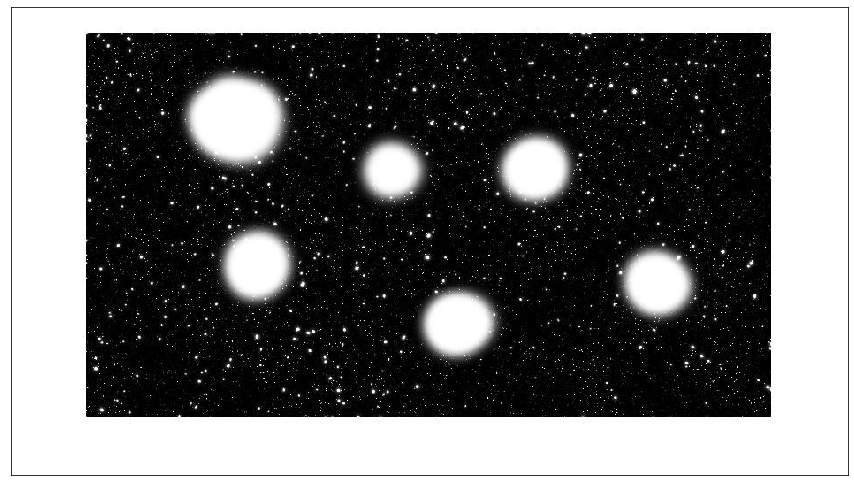

In [24]:
fig = plota([entrada])

-------

# Preparação da Imagem

Nesta etapa fazemos a preparação da imagem.

Para identificar as circunferências, primeiro fizemos a limiarização das duas imagens carregadas. Essa limiarização tem o objetivo de deixar bem delimitado os espaços que cada objeto dentro da imagem ocupa, e remover a degrade que aparece entorno das cincunferências grandes, como podemos ver abaixo.

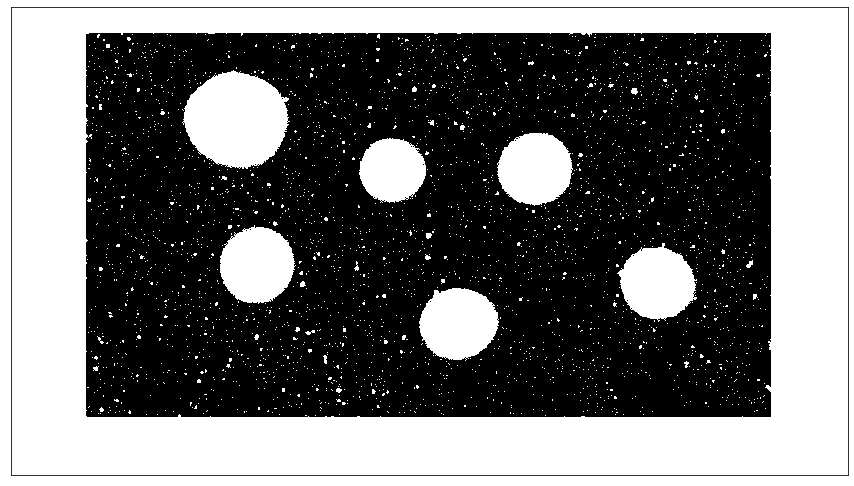

In [25]:
entrada_thres = img_threshold(entrada).astype(np.uint8)
fig = plota([entrada_thres])

Para limpar o ruido das imagens, que seriam os pequenos pontos brancos, aplicamos um filtro mediano. Pegamos o resultado do filtro mediano, e aplicamos o filtro sobel para deixar apenas as bordas dos objetos na imagem.

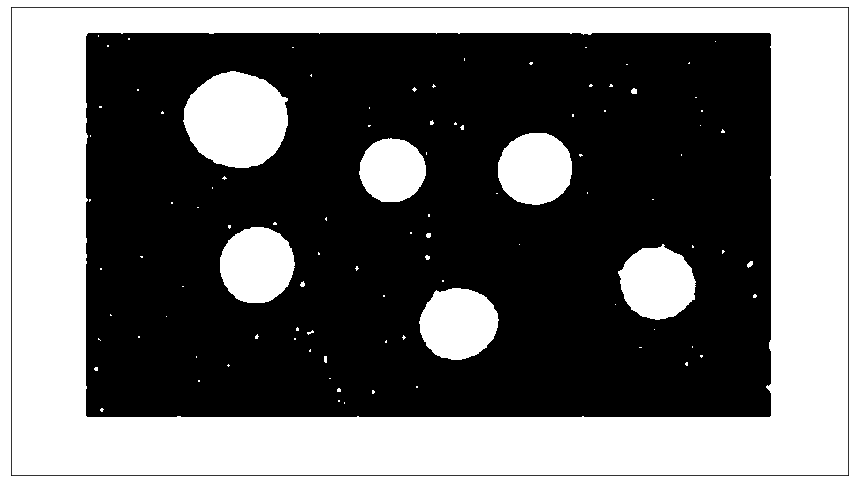

In [29]:
entrada_thres_med = cv.medianBlur(entrada_thres, 5)
fig = plota([entrada_thres_med])

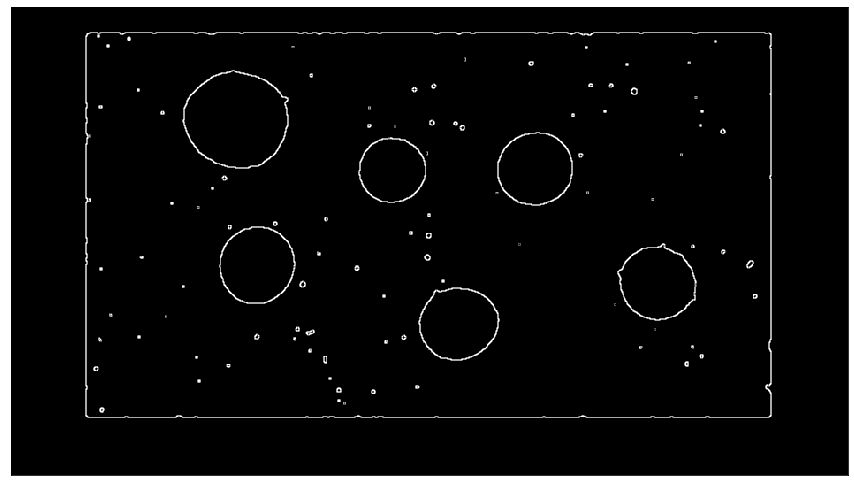

In [32]:
entrada_thres_med_sob = sobel(entrada_thres_med)
fig = plota([entrada_thres_med_sob])

Para deixar mais em evidência os objetos da image depois do filtro sobel ter sido aplicado, fazemos a binarização da imagem.

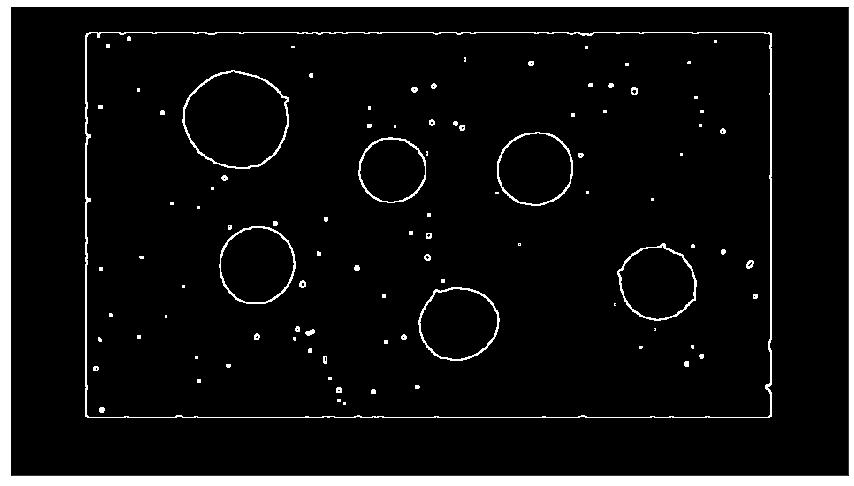

In [36]:
sob_bin = img2binary(np.copy(entrada_thres_med_sob))
fig = plota([sob_bin])

Uma vez que temos a imagem acima, podemos remover as bordas horizontais e verticais. O motivo de remover estas bordas é ter menos pontos que serão usados na transformada de Hough. A sequência de imagens a seguir mostra as bordas horizontais e verticais que foram identificadas.

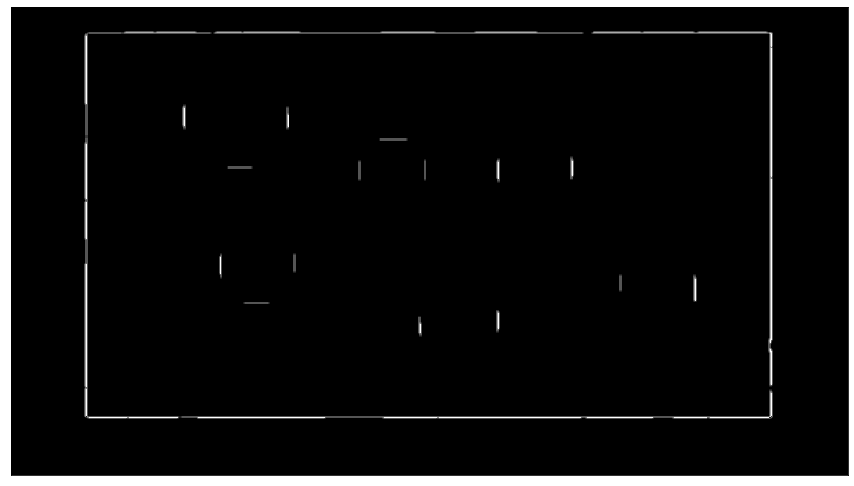

In [37]:
test = remove_straight_edges(sob_bin)
fig = plota([test])

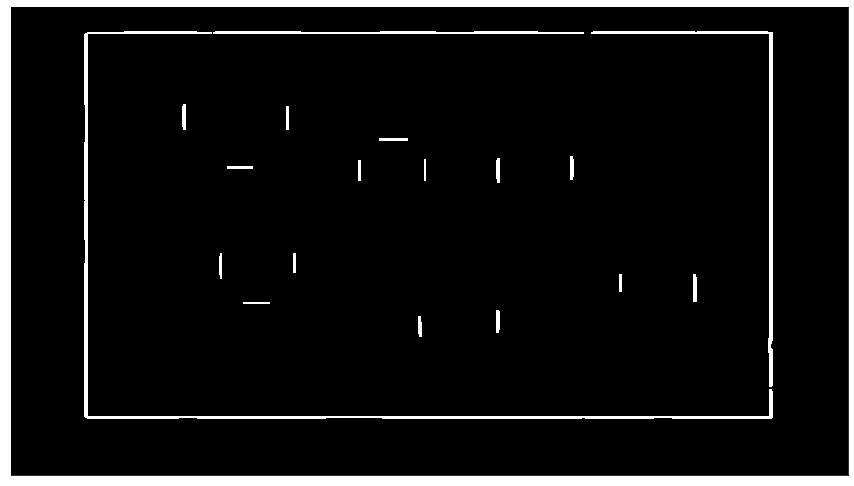

In [40]:
test[np.where(test != 0)] = 255
fig = plota([test])

Agora com as bordas separadas podemos fazer a subtração delas da imagem com filtro sobel. Assim temos uma imagem final que possui apenas alguns pontos e as circunferências grandes.

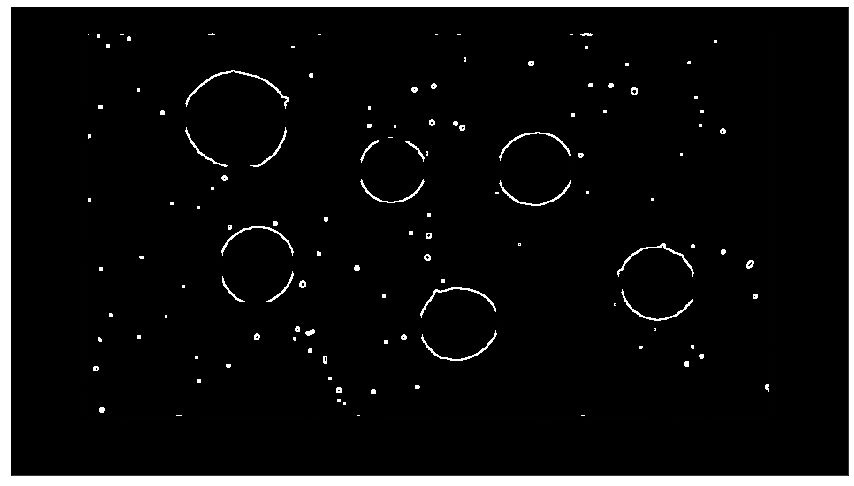

In [42]:
img_test = sob_bin*255 - test
fig = plota([img_test])

-------

# Transformada Circular de Hough

Uma vez que temos a imagem, que iremos usar na transformada de Hough (imagem acima), definimos os pontos no domínio de Hough.

O domínio de Hough, neste caso circular, tem as seguintes coordenadas $(r, r\cos(\theta), r\sin(\theta))$. Essas coordenadas dependem do tamanho da abertura do raio, isto é, temos que definir o valor mínimo e máximo do tamanho do raio em que será feita a busca pelas circunferências. O tamanho dessa abertura é importante para o tempo de execução da busca.

In [43]:
n_rows, n_cols = img_test.shape

In [44]:
steps = 101
points = []

In [45]:
r_min = 31
r_max = 61

In [46]:
for rr in range(r_min, r_max + 1):
    for t in range(steps):
        points.append((rr, 
                       int(rr * np.cos(2 * np.pi * t / steps)),
                       int(rr * np.sin(2 * np.pi * t / steps))))

Para cada ponto na imagem de entrada da transformada, fazemos a varredura nos pontos no domínio de Hough, e caso haja algum pixel, para aquela coordenada $(r, r\cos(\theta), r\sin(\theta))$, temos um mapa onde acumulamos os valores. 

In [47]:
xyr = np.zeros([n_rows + 1, n_cols + 1, r_max + 1])
acc = defaultdict(int)

In [48]:
for cy in np.arange(n_rows):
    for cx in np.arange(n_cols):
        if img_test[cy, cx] > 0:    
            for r, y, x in points:
                if ((y + cy) > n_rows) or ((y + cy) < 0): continue
                if ((x + cx) > n_cols) or ((x + cx) < 0): continue
                xyr[y + cy, x + cx, r] += 1
                acc[(y + cy, x + cx, r)] += 1

Assim, para cada valor de raio, temos um plano dos pontos da imagem de entrada que foram transformados para o domínio de Hough. Podemos pegar este planos todos e somar, tendo um acumulador geral, que é a imagem abaixo. Os pixels de maior intensidade, tons amarelos/verde, mostra o centro de cada uma das circunferências.

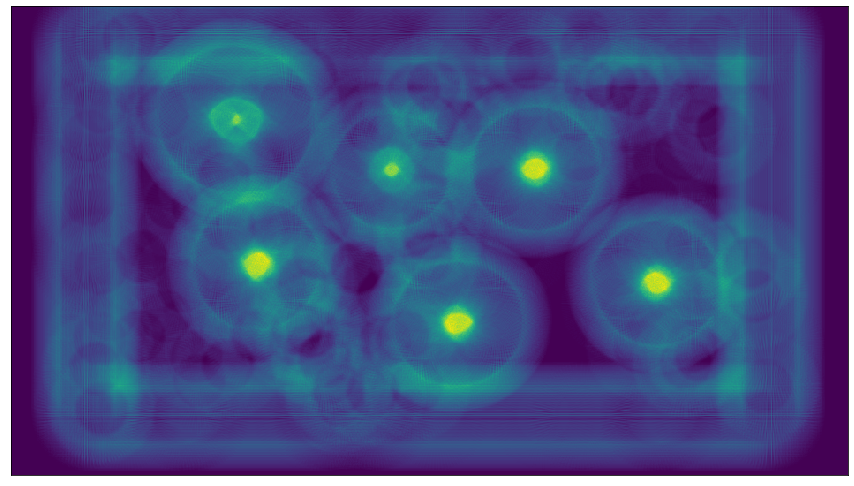

In [49]:
fig = plota([xyr.sum(axis = 2)], gray = False)

In [52]:
threshold = 0.3

Abaixo temos as coordenadas $(x, y)$ de cada um dos centros das circunferências e seu respectivo raio. 

In [53]:
circles = []
for k, v in sorted(acc.items(), key=lambda i: -i[1]):
    y, x, r = k
    if v / steps >= threshold and all((y - cy)**2 +
                                      (x - cx)**2 > rc**2 
                                      for cy, cx, rc in circles):
#         print('{:.4f}: {:5d} {:5d} {:5d}'.format(v / steps, y, x, r))
        circles.append((y, x, r))

0.7624:   185   431    37
0.7525:   184   593    42
0.7129:   292   278    43
0.7129:   313   731    42
0.5743:   359   504    42
0.4950:   127   249    53


In [39]:
circles

[(185, 431, 37),
 (184, 593, 42),
 (292, 278, 43),
 (313, 731, 42),
 (359, 504, 42),
 (127, 249, 53)]

Com os valores das coordenadas e do raio, podemos traçar cada uma das circunferências na imagem de entrada.

In [54]:
red = (255, 0, 0)
saida_final = cv.cvtColor(np.copy(entrada), cv.COLOR_GRAY2BGR)
for y, x, r in circles:
#     print(y, x, r)
    cv.circle(saida_final, (x, y), r, red, thickness = 1)

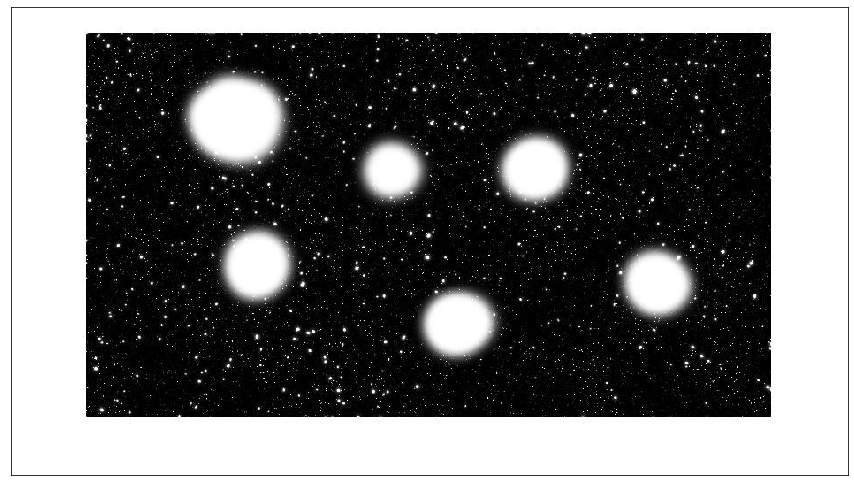

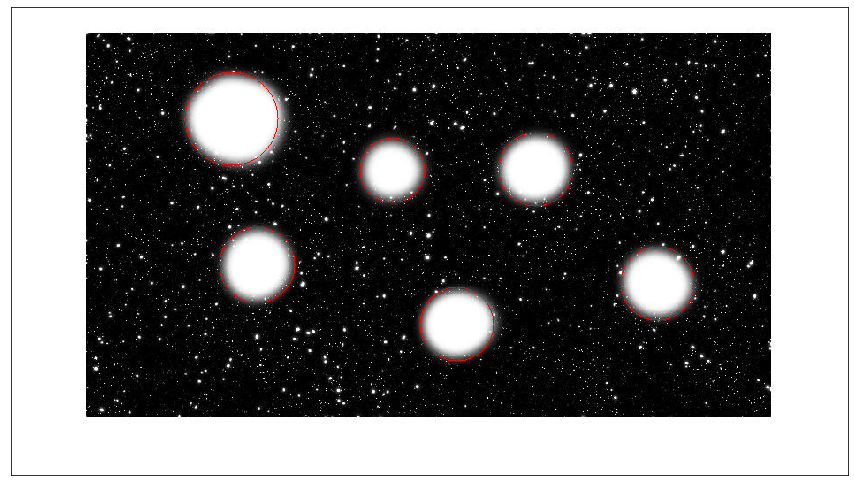

In [55]:
fig = plota([entrada])
fig = plota([saida_final], gray = False)